In [1]:
import pandas as pd
import numpy as np
# from pandas_profiling import ProfileReport
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt

In [2]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
df = pd.read_csv("/home/gui/Área de Trabalho/DS_challenge/DS_challenge/SourceFiles/ofertas_relampago.csv")#.head(100)
df.head()

OFFER_START_DATE           OFFER_START_DTTM          OFFER_FINISH_DTTM  \
0       2021-06-22  2021-06-22 16:00:00+00:00  2021-06-22 23:02:43+00:00   
1       2021-06-22  2021-06-22 13:00:00+00:00  2021-06-22 19:00:02+00:00   
2       2021-06-22  2021-06-22 07:00:00+00:00  2021-06-22 13:00:01+00:00   
3       2021-06-22  2021-06-22 19:00:00+00:00  2021-06-23 01:36:12+00:00   
4       2021-06-22  2021-06-22 13:00:00+00:00  2021-06-22 15:48:12+00:00   

       OFFER_TYPE  INVOLVED_STOCK  REMAINING_STOCK_AFTER_END  SOLD_AMOUNT  \
0  lightning_deal               4                         -2         4.72   
1  lightning_deal               5                          5          NaN   
2  lightning_deal              15                         12        10.73   
3  lightning_deal              15                         13         7.03   
4  lightning_deal              15                          0        39.65   

   SOLD_QUANTITY ORIGIN SHIPPING_PAYMENT_TYPE DOM_DOMAIN_AGG1 VERTICAL  \
0            6.0      A                  none       PETS FOOD      CPG   
1            NaN    NaN         free_shipping    PET PRODUCTS   OTHERS   
2            3.0    NaN                  none       COMPUTERS       CE   
3            2.0    NaN                  none       COMPUTERS       CE   
4           15.0    NaN                  none       COMPUTERS       CE   

                     DOMAIN_ID  
0               MLM-BIRD_FOODS  
1  MLM-ANIMAL_AND_PET_PRODUCTS  
2                 MLM-SPEAKERS  
3               MLM-HEADPHONES  
4               MLM-HEADPHONES

In [4]:
profile = ProfileReport(df, title="My Data Profile")
# profile.to_widgets()
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Primeiras Ideias 
 - _OFFER_TYPE_ parece ser um identificador para as "ofertas relâpago" e apresenta um valor constante neste dataset, portanto não usarei nas análises

 - _ORIGIN_ também parece ser algum tipo de identificador, menos de 1 quarto dos dados aprensenta um valor e sempre o mesmo, não sei dizer o que significa, também não usarei nas análises

 - _OFFER_START_DATE_ possui um range de 2 meses apenas e nenhum valor faltante, podemos criar outra variável ao identificar os dias da semana, e analisar o TPV em finais de semana 

 - _OFFER_START_DTTM_ e _OFFER_FINISH_DTTM_ trazem uma janela em que a oferta ficou disponível, podemos analisar o impacto do tamanho dessa janela no TPV, seria interessante ver o volume de vendas distribuído ao decorrer da janela (será que as vendas aumentam próximo do fim?), mas não temos os dados das vendas individuais. Também podemos analizar o volume de vendas em janelas de diferentes períodos, ex. fim de tarde, e fora de horário comercial. 

 - _REMAINING_STOCK_AFTER_END_ esta variável possui valores negativos, isso sugere que houve mais vendas do que havia de produtos em estoque? qual seria o impacto disso no negócio? podemos analizar se há um padrão nos produtos/janelas que isso ocorre.

 - _SOLD_AMOUNT_ e _SOLD_QUANTITY_ serão uteis pra calcular o TPV de ofertas, e podemos utilizar pra quantificar o sucesso de produtos/janelas de ofertas.

 - _SHIPPING_PAYMENT_TYPE_ parece interessante para correlacionar com produtos, mas o domínio é muito pequeno sendo _free_shipping_ o único valor presnte, não sei dizer se a falta de valor corresponde necessáriamente a um valor diferente de _free_shipping_.

 - _DOM_DOMAIN_AGG1_ e _VERTICAL_ parecem ser  categorias hierárquicas dos produtos, podemos identificar as verticais de produtos em que as ofertas relampago conseguem uma maior aderência.

- _DOMAIN_ID_ parece identificar um tipo de produto específico, possui um domínio bem grande.


# Feature Engineering

% of <24h:  0.9999794854962458


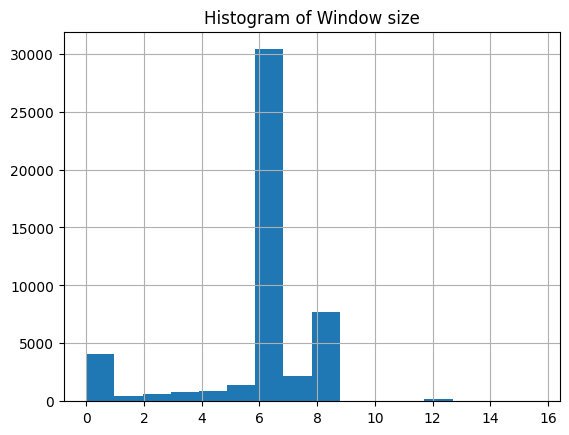

In [17]:
df['OFFER_DATE'] = pd.to_datetime(df['OFFER_START_DATE'])
df['OFFER_WEEK_DAY'] = df.OFFER_DATE.dt.weekday # Monday is 0 and Sunday is 6
day_names = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'saunday']
df['OFFER_WEEK_DAY_NAME'] = df.OFFER_WEEK_DAY.apply(lambda x: day_names[x])
df['OFFER_WEEKEND'] = df.OFFER_WEEK_DAY.apply(lambda x: int(x in (5,6)))

df['OFFER_LENGTH_IN_HOURS'] = (pd.to_datetime(df['OFFER_FINISH_DTTM']) - pd.to_datetime(df['OFFER_START_DTTM'])).dt.total_seconds() / 3600
# df['OFFER_HOURS'] = df.apply(lambda x: [pd.to_datetime(x.OFFER_START_DTTM).hour + h for h in range(round(x.OFFER_LENGTH_IN_HOURS)+1)], axis=1)

# df.loc[df.OFFER_LENGTH_IN_HOURS < 24].size
print("% of <24h: ", df.loc[df.OFFER_LENGTH_IN_HOURS < 24].size/df.size)
df['OFFER_LENGTH_IN_HOURS'].loc[df.OFFER_LENGTH_IN_HOURS < 24].hist(bins=16)
plt.title("Histogram of Window size")
plt.show()

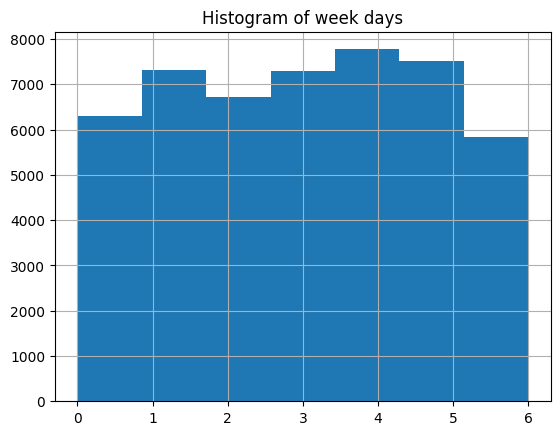

In [6]:
df['OFFER_WEEK_DAY'].hist(bins=7)
plt.title("Histogram of week days")
plt.show()

A maioria das janelas tem um tamanho de 6h e estão bem distribuídas pelos dias da semana, com um número levemente menor aos domingos

## Classificação do periodo da janela de oferta

In [7]:
labels = ['NIGHT', 'MORNING', 'AFTERNOON', 'EVENING']
bins = [0, 6, 12, 18, 24]

def time_of_day_percentage(x):
    start_time = pd.to_datetime(x.OFFER_START_DTTM)
    duration = x.OFFER_LENGTH_IN_HOURS
    duration = duration if duration > 0  else 1
    hours = [start_time.hour + h for h in range(round(duration)+1)]
    part_of_day = pd.cut(hours, bins=bins, labels=labels, right=False, include_lowest=True)
    return part_of_day.value_counts()/part_of_day.value_counts().sum()

time_of_day_percentage(df.iloc[0])

NIGHT        0.00
MORNING      0.00
AFTERNOON    0.25
EVENING      0.75
Name: count, dtype: float64

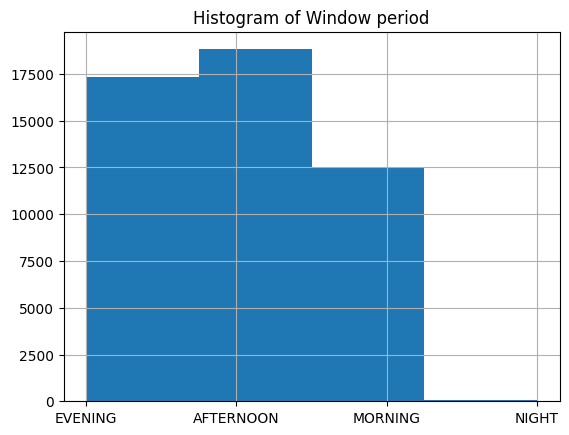

In [ ]:
df[[f'OFFER_PERCENTAGE_AT_{l}' for l in labels]] = df.apply(lambda x: time_of_day_percentage(x), axis=1, result_type='expand')
df[f'OFFER_PERIOD_ID'] = df.apply(lambda x: np.argmax([x[f'OFFER_PERCENTAGE_AT_{l}'] for l in labels]), axis=1)
df[f'OFFER_PERIOD'] = df.OFFER_PERIOD_ID.apply(lambda x: labels[x])
df[f'OFFER_PERIOD_START'] = pd.cut(pd.to_datetime(df.OFFER_START_DTTM).dt.hour, bins=bins, labels=labels, right=False, include_lowest=True)
df[f'OFFER_PERIOD_END'] = pd.cut(pd.to_datetime(df.OFFER_FINISH_DTTM).dt.hour, bins=bins, labels=labels, right=False, include_lowest=True)

df[[f'OFFER_PERCENTAGE_AT_{l}' for l in labels]+['OFFER_PERIOD']]


df['OFFER_PERIOD'].hist(bins=4)
plt.title("Histogram of Window period")
plt.show()


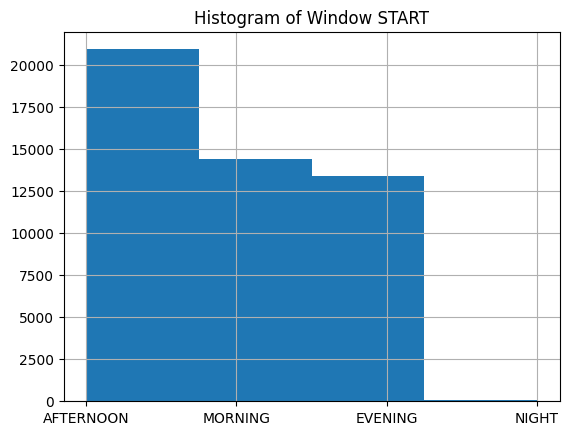

In [14]:
df['OFFER_PERIOD_START'].hist(bins=4)
plt.title("Histogram of Window START")
plt.show()

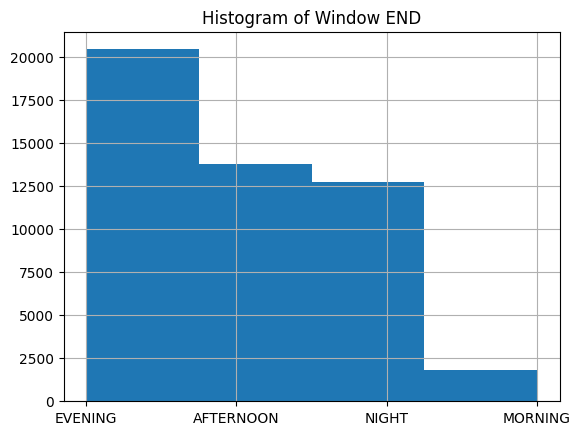

In [13]:
df['OFFER_PERIOD_END'].hist(bins=4)
plt.title("Histogram of Window END")
plt.show()

A maioria das janelas tem contemplam mais as tardes e noites, com um número considerável as manhãs mas bem poucas de madrugada.

Vemos também que as jenalas mais comuns são as que iniciam a tarde e terminam a noite.

## Aggregations

In [33]:
cols = ['OFFER_WEEK_DAY', 'OFFER_WEEKEND', 'OFFER_PERIOD', 'OFFER_PERIOD_START', 'OFFER_PERIOD_END', 'SHIPPING_PAYMENT_TYPE', 'DOMAIN_ID', 'DOM_DOMAIN_AGG1', 'VERTICAL']
values = ['SOLD_AMOUNT', 'SOLD_QUANTITY', "INVOLVED_STOCK", "REMAINING_STOCK_AFTER_END"]
agg = {
    k : df[values + [k]].groupby([k]).sum()[values]
    for k in cols
}


In [34]:
for i,v in agg.items():
    print(v.sort_values('SOLD_AMOUNT', ascending=False).head())

                SOLD_AMOUNT  SOLD_QUANTITY  INVOLVED_STOCK  \
OFFER_WEEK_DAY                                               
1                 218777.41        48215.0          281032   
2                 204655.07        44042.0          251896   
0                 197662.01        44868.0          266781   
3                 194487.42        42189.0          256434   
4                 177677.12        38064.0          268956   

                REMAINING_STOCK_AFTER_END  
OFFER_WEEK_DAY                             
1                                  242728  
2                                  217042  
0                                  231092  
3                                  225013  
4                                  236212  
               SOLD_AMOUNT  SOLD_QUANTITY  INVOLVED_STOCK  \
OFFER_WEEKEND                                               
0                993259.03       217378.0         1325099   
1                265404.47        49330.0          381377   

            

- O _DOMAIN_ID_ mais comum é _MLM-SURGICAL_AND_INDUSTRIAL_MASKS_ e as datas dessa amostra correspondem a um período da pandemia de COVID19.

-  Os estoques não aprecem ser fixos durante a janela ja que _REMAINING_STOCK_AFTER_END_ não parece ser apenas (_INVOLVED_STOCK_ - _SOLD_QUANTITY_)

- Terças e Quartas Feiras parecem ser dias de maiores vendas apesar de não serem os dias com maior número de ofertas.


In [32]:
num_cols = ['SOLD_AMOUNT','SOLD_QUANTITY','OFFER_LENGTH_IN_HOURS','OFFER_WEEK_DAY','OFFER_WEEKEND','OFFER_PERIOD_ID']
df[num_cols].corr()

SOLD_AMOUNT  SOLD_QUANTITY  OFFER_LENGTH_IN_HOURS  \
SOLD_AMOUNT               1.000000       0.708884               0.120777   
SOLD_QUANTITY             0.708884       1.000000               0.061757   
OFFER_LENGTH_IN_HOURS     0.120777       0.061757               1.000000   
OFFER_WEEK_DAY           -0.040341      -0.046727              -0.000044   
OFFER_WEEKEND            -0.031599      -0.039928              -0.018249   
OFFER_PERIOD_ID           0.046706       0.028402               0.078687   

                       OFFER_WEEK_DAY  OFFER_WEEKEND  OFFER_PERIOD_ID  
SOLD_AMOUNT                 -0.040341      -0.031599         0.046706  
SOLD_QUANTITY               -0.046727      -0.039928         0.028402  
OFFER_LENGTH_IN_HOURS       -0.000044      -0.018249         0.078687  
OFFER_WEEK_DAY               1.000000       0.771966        -0.018029  
OFFER_WEEKEND                0.771966       1.000000        -0.023888  
OFFER_PERIOD_ID             -0.018029      -0.023888         1.000000

In [ ]:
profile = ProfileReport(df[cols], title="My Data Profile")
# profile.to_widgets()
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]